In [1]:
import torch
from torch import Tensor
import torch.nn.functional as F
import transformer_lens
from transformer_lens import HookedTransformer, HookedTransformerConfig
from einops import einsum

from jaxtyping import Int, Float
from typing import List, Tuple, Optional, Literal
import numpy as np
from transformer_lens import utils
import matplotlib.pyplot as plt

from interp_utils import get_layer_attributions, decomposed_head_attribs
from plot_utils import visualize_transformer_attributions, get_and_visualize_model_attributions

In [2]:
model = HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
text = "James"
target_idx = model.to_single_token(' Cameron')
target_idx = 2922
model.to_str_tokens(text)
# target_idx
# model.to_string(target_idx)
model.to_str_tokens(model(text)[0, -1].argsort(dim=-1)[-10:])

[',', ' H', ' Cameron', ' M', ' Bond', ' T', ' C', ' "', ' O', ' D']

In [4]:
logits, cache = model.run_with_cache(text, remove_batch_dim=True)

In [6]:
cache["blocks.0.mlp.hook_pre"].size(), cache["blocks.0.mlp.hook_post"].size(), cache["blocks.0.hook_mlp_out"].size()

(torch.Size([2, 3072]), torch.Size([2, 3072]), torch.Size([2, 768]))

In [7]:
dcm_head_attribs = decomposed_head_attribs(model, cache, target_idx)
dcm_head_attribs.sum(dim=-1)
dcm_head_attribs.size()    # n_layers, n_heads

torch.Size([12, 12])

In [8]:
attn_layer_attribs = get_layer_attributions(model, "attn", cache, target_idx)
mlp_layer_attribs = get_layer_attributions(model, "mlp", cache, target_idx)
attn_layer_attribs, mlp_layer_attribs

(tensor([-2.4611,  0.8942, -0.1199, -0.1026,  0.2524, -0.4731,  0.2113,  0.3950,
          0.3063,  0.4939,  1.2879, -0.3420]),
 tensor([-5.2514,  4.0838,  0.8811,  3.5424,  0.9213, -1.2920,  0.6326,  0.9091,
         -0.4497, -2.1337, -5.6574, -5.6366]))

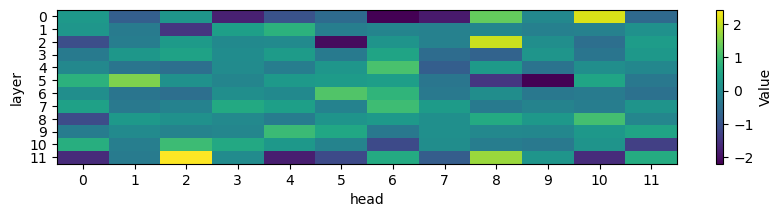

In [9]:
detached_dcm_head_attribs = dcm_head_attribs.detach().cpu().numpy()
detached_mlp_layer_attribs = mlp_layer_attribs.detach().cpu().numpy()

plt.figure(figsize=(10, 2), dpi=100)
plt.imshow(detached_dcm_head_attribs, cmap="viridis", aspect="auto")
plt.xticks(range(12))
plt.xlabel("head")
plt.yticks(range(12))
plt.ylabel("layer")
plt.colorbar(label='Value')
plt.show()

In [10]:
# TheA.CAlkdTheA.CAlk

In [12]:
model.to_string(4371)

' progress'

In [17]:
get_and_visualize_model_attributions(
    model=model,
    input_str="James",
    target_idx = 4371,
    show_node_labels=False,
    use_normalized_colors=False,
    show_colorbar=True,
    save_path="james-progress.png",
)

Figure saved to james-progress.png


In [13]:
# 1.find the absolute contributions - removing mean contribution of layers